Number of failed tests: 2


/usr/local/lib/python2.7/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


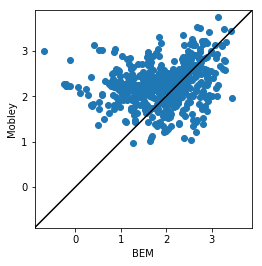

In [3]:
import numpy
from matplotlib import pyplot
%matplotlib inline

bem = numpy.loadtxt('energy_bem_phi11.txt')
mobley = numpy.loadtxt('mobley_results_clean.txt')
names = numpy.loadtxt('actually_all_names.txt', dtype=str)
volumes = numpy.loadtxt('volumes.txt')
areas = numpy.loadtxt('areas.txt')

index_clean = numpy.where(abs(bem)>1e-12)[0]

print 'Number of failed tests: %i'%(len(bem)-len(index_clean))

fig,ax = pyplot.subplots()
ax.scatter(mobley[index_clean], bem[index_clean])

lims = [ 
    numpy.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    numpy.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.plot(numpy.array([lims[0],lims[1]]), numpy.array([lims[0],lims[1]]), c='k')

ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('BEM')
ax.set_ylabel('Mobley')
fig.show()

In [4]:
index_fail = numpy.where(abs(bem)<1e-12)[0]
index_fail

array([229, 341])

In [5]:
names[229], names[341]

('ammonia', 'hydrogen_sulfide')

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

bem_c = bem[index_clean]
mobley_c = mobley[index_clean]
names_c = names[index_clean]
volumes_c = volumes[index_clean]
areas_c = areas[index_clean]


key = 'propane'
key_true = numpy.chararray(len(bem_c), itemsize=10)
key_true[:] = 'blue'
for i in range(len(bem_c)):
    if key in names_c[i]:
        key_true[i] = 'red'
    
trace = go.Scatter(
            x = mobley_c,
            y = bem_c,
            text = names_c,
            mode='markers',
            marker = dict(size=8,
                        opacity=0.6, color=key_true),
            hoverinfo = 'text')
         

max_val = numpy.max(mobley_c)
ref = go.Scatter( x = numpy.array([0,max_val]),
                  y = numpy.array([0,max_val]),
                  mode = 'lines'
                )


data = [trace, ref]
    
layout= go.Layout(
    title= 'BEM vs Explicit Nonpolar Solvation Energy',
    hovermode= 'closest',
    xaxis= dict(
        title= 'Explicit',
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= 'BEM',
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)
fig= go.Figure(data=data, layout=layout)
iplot(fig)

ImportError: No module named plotly.plotly